In [1]:
# This notebook is for diffusion parcellation using HCPMMP cortical parcellation matrix and gradient approach for HCP UR100 subjects (N=100).

# Includes:
#     Connectivity matrix
#     Gradients calculation
#     Variance explained
#     BF gradient weighted Cortical Projection
#     Cortical RS Network associated to Upper and Lower 25% and 10% of BF gradient
#     Upper and Lower 25% and 10% of BF gradient cortical projection
#     Gradient x Atlas subregion comparison

In [1]:
import os
from numpy import load
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
import pandas as pd
import nibabel as nib
from nilearn.plotting import view_img, plot_glass_brain, plot_anat, plot_roi
from brainspace.datasets import load_fsa5
from brainspace.plotting import plot_hemispheres
from brainspace.datasets import load_parcellation
from brainspace.utils.parcellation import map_to_labels
from neuromaps import images
from nilearn import plotting
import plotly.graph_objects as go

/home/ROBARTS/schakraborty/venv/lib/python3.9/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


### Setting the path

In [2]:
# get the current notebook path
note_path = "/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/HumanBF-Parcellation/notebook/"
data_path = "/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/HumanBF-Parcellation/data/"
results_path = "/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/HumanBF-Parcellation/results/Diff_UR100/"
fig_path = "/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/HumanBF-Parcellation/results/figures/Diff_UR100/"

### Get the connectivity matrix

In [3]:
# load npz data
data = load(data_path + 'tpl-MNI152NLin6Asym_label-fullBF_desc-concat_from-UR100_connMap.npz')
correlation = data['conn_group']

In [4]:
# Average correlation matrix
corr_avg = np.nanmean(correlation,axis=0)
corr_avg += 1
corr_avg[np.isnan(corr_avg)] = 1

In [5]:
# Reshape and concatenate subjects
corr = np.moveaxis(correlation,0,2)
corr_concat = corr.reshape([corr.shape[0],corr.shape[1]*corr.shape[2]])
corr_concat += 1 # Spectral clustering doesn't like negative input apparantly, or square
corr_concat[np.isnan(corr_concat)] = 1

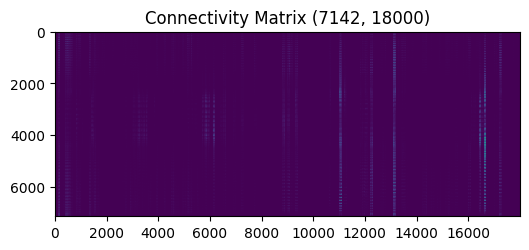

In [7]:
# Plot this matrix.
f, ax = plt.subplots(1,1,dpi=100)
ax.imshow(corr_concat)
ax.set_title('Connectivity Matrix {}'.format(corr_concat.shape))
plt.show()

### Calculate Gradient

In [11]:
#Average data
from brainspace.gradient import GradientMaps

# Build gradients using diffusion maps and normalized angle and fit to the data.
gm = GradientMaps(n_components=10, 
                  kernel='normalized_angle',
                  approach='dm',
                  random_state=0)
print(gm.fit(corr_avg))

GradientMaps(kernel='normalized_angle', random_state=0)


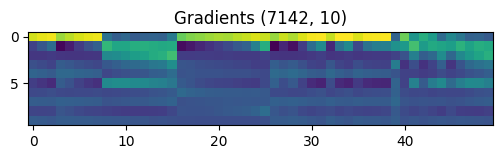

In [10]:
# Plot this gradients.
f, ax = plt.subplots(1,1,dpi=100)
ax.imshow(gm.gradients_[:50].T)
ax.set_title('Gradients {}'.format(gm.gradients_.shape))
plt.show()

In [11]:
# save the gradient
pd.DataFrame(gm.gradients_).to_csv(results_path + 'Diff_UR100_gradients_seed-BASF_0p7mm.csv')

In [14]:
# save the BF gradients niftis
# get seed data
seed_file = (data_path + 'fullBF_B_MNI152NLin6Asym_mask.nii.gz')
seed = nib.load(seed_file)
seed_vol = seed.get_fdata()
mask = data['mask']
affine = data['affine']

for gradi in range(5):

    grad_vol = np.zeros(mask.shape)
    grad_vol[mask > 0] = gm.gradients_[:,gradi]
    
    grad_nib = nib.Nifti1Image(grad_vol,affine,header=seed.header)
    grad_nib.to_filename(results_path + f'Diff_UR100_gradient_{gradi}.nii.gz')

### Calculate Variance

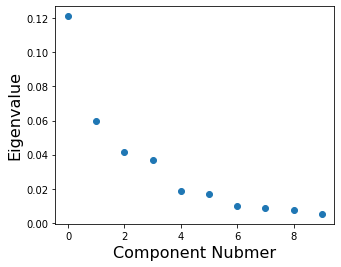

In [15]:
fig, ax = plt.subplots(1, figsize=(5, 4))
ax.scatter(range(gm.lambdas_.size), gm.lambdas_)
ax.set_xlabel('Component Nubmer', fontsize=16)
ax.set_ylabel('Eigenvalue', fontsize=16)
plt.savefig(fig_path + f'Diff_UR100_Gradient_variance.png')
plt.show()

### Visualize Gradients

In [24]:
# save figures
gradi = 3
grad_nib = nib.load(results_path + f'Diff_UR100_gradient_{gradi}.nii.gz')
color = matplotlib.cm.get_cmap('PRGn')
plot_glass_brain(grad_nib, colorbar=True, title=(f'Diff UR100 Gradient '+ str(gradi+1)), display_mode='lyrz', plot_abs=False, cmap=color, output_file=(fig_path + f'Diff_UR100_Gradient_'+ str(gradi+1)+'.png'))

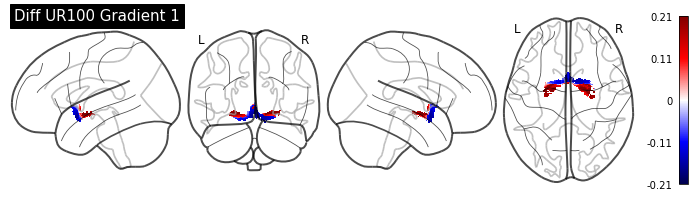

In [16]:
# display figures
gradi = 0
grad_nib = nib.load(results_path + f'Diff_UR100_gradient_{gradi}.nii.gz')
color = matplotlib.cm.get_cmap('seismic')
plot_glass_brain(grad_nib, colorbar=True, title=(f'Diff UR100 Gradient '+ str(gradi+1)), display_mode='lyrz', plot_abs=False, cmap=color)

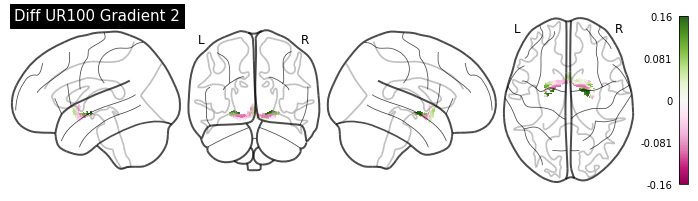

In [17]:
gradi = 1
grad_nib = nib.load(results_path + f'Diff_UR100_gradient_{gradi}.nii.gz')
color = matplotlib.cm.get_cmap('PiYG')
plot_glass_brain(grad_nib, colorbar=True, title=(f'Diff UR100 Gradient '+ str(gradi+1)), display_mode='lyrz', plot_abs=False, cmap=color)

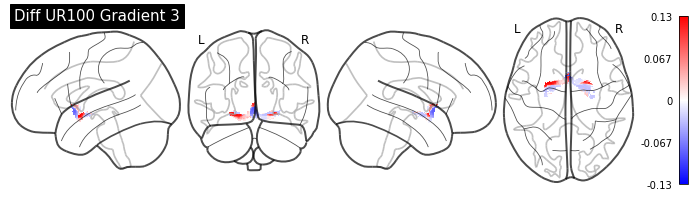

In [19]:
gradi = 2
grad_nib = nib.load(results_path + f'Diff_UR100_gradient_{gradi}.nii.gz')
color = matplotlib.cm.get_cmap('bwr')
plot_glass_brain(grad_nib, colorbar=True, title=(f'Diff UR100 Gradient '+ str(gradi+1)), display_mode='lyrz', plot_abs=False, cmap=color)

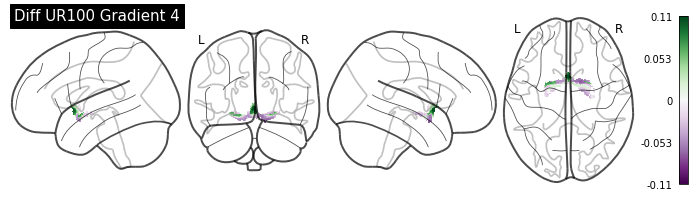

In [20]:
gradi = 3
grad_nib = nib.load(results_path + f'Diff_UR100_gradient_{gradi}.nii.gz')
color = matplotlib.cm.get_cmap('PRGn')
plot_glass_brain(grad_nib, colorbar=True, title=(f'Diff UR100 Gradient '+ str(gradi+1)), display_mode='lyrz', plot_abs=False, cmap=color)

### BF-gradient weighted corical projection

In [9]:
# expand the corr_avg to match 360 cortical targets and get log-sclaed avgFC
corr_avgFC = np.concatenate((corr_avg,corr_avg), axis=1)
log_corr_avgFC = np.log(corr_avgFC)

In [54]:
# Gradient 1
G1_Ctx = np.zeros(corr_avgFC.shape)
for i in range(len(gm.gradients_[:,0])):
    G1_Ctx[i,:] = log_corr_avgFC[i,:]*gm.gradients_[i,0]
G1fc = np.nanmean(G1_Ctx,axis=0).reshape([360,1])

In [55]:
# Gradient 2
G2_Ctx = np.zeros(corr_avgFC.shape)
for i in range(len(gm.gradients_[:,1])):
    G2_Ctx[i,:] = log_corr_avgFC[i,:]*gm.gradients_[i,1]
G2fc = np.nanmean(G2_Ctx,axis=0).reshape([360,1])

In [56]:
# Gradient 3
G3_Ctx = np.zeros(corr_avgFC.shape)
for i in range(len(gm.gradients_[:,2])):
    G3_Ctx[i,:] = log_corr_avgFC[i,:]*gm.gradients_[i,2]
G3fc = np.nanmean(G3_Ctx,axis=0).reshape([360,1])

In [57]:
# Gradient 4
G4_Ctx = np.zeros(corr_avgFC.shape)
for i in range(len(gm.gradients_[:,3])):
    G4_Ctx[i,:] = log_corr_avgFC[i,:]*gm.gradients_[i,3]
G4fc = np.nanmean(G4_Ctx,axis=0).reshape([360,1])

In [58]:
# setting up for cortical projection using brainspace
surf_lh, surf_rh = load_fsa5()

surf_labels_lh = nib.freesurfer.read_annot(data_path + 'lh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh = nib.freesurfer.read_annot(data_path + 'rh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh[surf_labels_rh != 0] += 180  # different labels for lh and rh
surf_labels = np.concatenate([surf_labels_lh, surf_labels_rh])

mask = surf_labels != 0  # discard medial wall

In [59]:
# Need to make it to log scale!!
G1cortex = map_to_labels(G1fc.reshape([360]),surf_labels, mask=mask, fill=np.nan)
G2cortex = map_to_labels(G2fc.reshape([360]),surf_labels, mask=mask, fill=np.nan)
G3cortex = map_to_labels(G3fc.reshape([360]),surf_labels, mask=mask, fill=np.nan)
G4cortex = map_to_labels(G4fc.reshape([360]),surf_labels, mask=mask, fill=np.nan)

In [26]:
# Plot on the surface and save as fig - Grad 1.
plot_hemispheres(surf_lh, surf_rh, array_name=[G1cortex], label_text=['Grad 1'],
    size=(900, 300),  cmap=['seismic'], color_bar=True, embed_nb=True, color_range='sym', screenshot=True, filename=fig_path+'Diff_UR100_Grad1_weighted_cortex.png' )

'/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/HumanBF-Parcellation/results/figures/Diff_UR100/Diff_UR100_Grad1_weighted_cortex.png'

In [27]:
# Plot on the surface and save as fig - Grad 2.
plot_hemispheres(surf_lh, surf_rh, array_name=[G2cortex], label_text=['Grad 2'],
    size=(900,300),  cmap=['PiYG'], color_bar=True, embed_nb=True, color_range='sym', screenshot=True, filename=fig_path+'Diff_UR100_Grad2_weighted_cortex.png')

'/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/HumanBF-Parcellation/results/figures/Diff_UR100/Diff_UR100_Grad2_weighted_cortex.png'

In [28]:
# Plot on the surface and save as fig - Grad 3.
plot_hemispheres(surf_lh, surf_rh, array_name=[G3cortex], label_text=['Grad 3'],
    size=(900,300),  cmap=['bwr'], color_bar=True, embed_nb=True, color_range='sym', screenshot=True, filename=fig_path+'Diff_UR100_Grad3_weighted_cortex.png')

'/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/HumanBF-Parcellation/results/figures/Diff_UR100/Diff_UR100_Grad3_weighted_cortex.png'

In [29]:
# Plot on the surface and save as fig - Grad 4.
plot_hemispheres(surf_lh, surf_rh, array_name=[G4cortex], label_text=['Grad 4'],
    size=(900,300),  cmap=['PRGn'], color_bar=True, embed_nb=True, color_range='sym', screenshot=True, filename=fig_path+'Diff_UR100_Grad4_weighted_cortex.png')

'/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/HumanBF-Parcellation/results/figures/Diff_UR100/Diff_UR100_Grad4_weighted_cortex.png'

In [60]:
# Save the cortical projection as gii files
G_cortex = [G1cortex, G2cortex, G3cortex, G4cortex]

for g in range(0, len(G_cortex)):
    gii_L = nib.gifti.GiftiImage()
    gii_L.add_gifti_data_array(
        nib.gifti.GiftiDataArray(G_cortex[g][:10242].astype(np.float32))) # For left hemisphere
    nib.save(gii_L, results_path+'Diff_UR100_Gradient-'+str(g+1)+'_weighted_L_fsa-10k.gii')

for g in range(0, len(G_cortex)):
    gii_R = nib.gifti.GiftiImage()
    gii_R.add_gifti_data_array(
        nib.gifti.GiftiDataArray(G_cortex[g][10242:].astype(np.float32))) # right hemisphere is [32492:]
    nib.save(gii_R, results_path+'Diff_UR100_Gradient-'+str(g+1)+'_weighted_R_fsa-10k.gii')

### Visualize BF-gradient weighted cortical projection

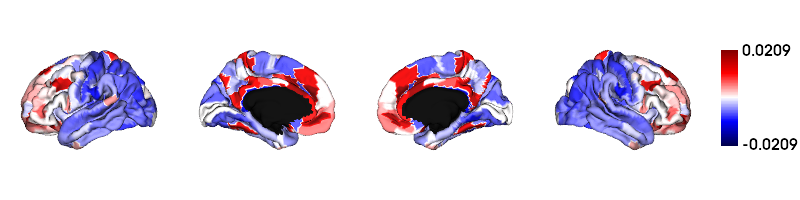

In [61]:
grad_L = images.load_gifti(results_path+'Diff_UR100_Gradient-4_weighted_L_fsa-10k.gii')
grad_R = images.load_gifti(results_path+'Diff_UR100_Gradient-4_weighted_R_fsa-10k.gii')
grad_L_data = grad_L.agg_data()
grad_R_data = grad_R.agg_data()
grad_data = np.concatenate((grad_L_data, grad_R_data))

surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[grad_data], size=(800, 200), cmap=['seismic'], color_range='sym', color_bar=True, embed_nb=True)

### Networks associated with upper and lower end of gradients

In [66]:
# load and prepare the label file
labels_txt = pd.read_csv(data_path+'hcp_mmp10_yeo7_modes.txt',header=None)
labels_txt[['Label','Hemisphere','Area','ROI','Network#','Network']]= labels_txt[0].str.split('_',expand=True)
networks = labels_txt['Network'].unique()

In [67]:
corr_avgFC_df = pd.DataFrame(corr_avgFC)
log_corr_avgFC_df = pd.DataFrame(log_corr_avgFC)
grad_mask_matrix = np.zeros(len(gm.gradients_[:,0]))
grad1_data = gm.gradients_[:,0]
grad2_data = gm.gradients_[:,1]
grad3_data = gm.gradients_[:,2]
grad4_data = gm.gradients_[:,3]

In [68]:
# Upper 10 and 25%
grad1_25upper = grad1_data >=  np.quantile(grad1_data, q=0.75) 
grad2_25upper = grad2_data >=  np.quantile(grad2_data, q=0.75) 
grad3_25upper = grad3_data >=  np.quantile(grad3_data, q=0.75) 
grad4_25upper = grad4_data >=  np.quantile(grad4_data, q=0.75) 
grad1_10upper = grad1_data >=  np.quantile(grad1_data, q=0.90) 
grad2_10upper = grad2_data >=  np.quantile(grad2_data, q=0.90) 
grad3_10upper = grad3_data >=  np.quantile(grad3_data, q=0.90) 
grad4_10upper = grad4_data >=  np.quantile(grad4_data, q=0.90) 
grad1_25upper_idx = np.where(grad1_25upper)[0]
grad2_25upper_idx = np.where(grad2_25upper)[0]
grad3_25upper_idx = np.where(grad3_25upper)[0]
grad4_25upper_idx = np.where(grad4_25upper)[0]
grad1_10upper_idx = np.where(grad1_10upper)[0]
grad2_10upper_idx = np.where(grad2_10upper)[0]
grad3_10upper_idx = np.where(grad3_10upper)[0]
grad4_10upper_idx = np.where(grad4_10upper)[0]

In [69]:
# Lower 10 and 25%
grad1_25lower = grad1_data <= np.quantile(grad1_data, q=0.25)
grad2_25lower = grad2_data <= np.quantile(grad2_data, q=0.25)
grad3_25lower = grad3_data <= np.quantile(grad3_data, q=0.25)
grad4_25lower = grad4_data <= np.quantile(grad4_data, q=0.25)
grad1_10lower = grad1_data <= np.quantile(grad1_data, q=0.10)
grad2_10lower = grad2_data <= np.quantile(grad2_data, q=0.10)
grad3_10lower = grad3_data <= np.quantile(grad3_data, q=0.10)
grad4_10lower = grad4_data <= np.quantile(grad4_data, q=0.10)
grad1_25lower_idx = np.where(grad1_25lower)[0]
grad2_25lower_idx = np.where(grad2_25lower)[0]
grad3_25lower_idx = np.where(grad3_25lower)[0]
grad4_25lower_idx = np.where(grad4_25lower)[0]
grad1_10lower_idx = np.where(grad1_10lower)[0]
grad2_10lower_idx = np.where(grad2_10lower)[0]
grad3_10lower_idx = np.where(grad3_10lower)[0]
grad4_10lower_idx = np.where(grad4_10lower)[0]

In [70]:
# Upper gradient log avgFC
grad1_25upperFC = log_corr_avgFC_df.iloc[grad1_25upper_idx,:]
grad2_25upperFC = log_corr_avgFC_df.iloc[grad2_25upper_idx,:]
grad3_25upperFC = log_corr_avgFC_df.iloc[grad3_25upper_idx,:]
grad4_25upperFC = log_corr_avgFC_df.iloc[grad4_25upper_idx,:]
grad1_10upperFC = log_corr_avgFC_df.iloc[grad1_10upper_idx,:]
grad2_10upperFC = log_corr_avgFC_df.iloc[grad2_10upper_idx,:]
grad3_10upperFC = log_corr_avgFC_df.iloc[grad3_10upper_idx,:]
grad4_10upperFC = log_corr_avgFC_df.iloc[grad4_10upper_idx,:]

In [71]:
# Lower gradient FC
grad1_25lowerFC = log_corr_avgFC_df.iloc[grad1_25lower_idx,:]
grad2_25lowerFC = log_corr_avgFC_df.iloc[grad2_25lower_idx,:]
grad3_25lowerFC = log_corr_avgFC_df.iloc[grad3_25lower_idx,:]
grad4_25lowerFC = log_corr_avgFC_df.iloc[grad4_25lower_idx,:]
grad1_10lowerFC = log_corr_avgFC_df.iloc[grad1_10lower_idx,:]
grad2_10lowerFC = log_corr_avgFC_df.iloc[grad2_10lower_idx,:]
grad3_10lowerFC = log_corr_avgFC_df.iloc[grad3_10lower_idx,:]
grad4_10lowerFC = log_corr_avgFC_df.iloc[grad4_10lower_idx,:]

In [72]:
grad1upper25_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = grad1_25upperFC.iloc[:,net_inds]
        net_mean.append(net_con_df.to_numpy().mean())

grad1upper25_matrix.append(net_mean)

In [73]:
grad1lower25_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = grad1_25lowerFC.iloc[:,net_inds]
        net_mean.append(net_con_df.to_numpy().mean())

grad1lower25_matrix.append(net_mean)

In [74]:
grad1upper10_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = grad1_10upperFC.iloc[:,net_inds]
        net_mean.append(net_con_df.to_numpy().mean())

grad1upper10_matrix.append(net_mean)

In [75]:
grad1lower10_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = grad1_10lowerFC.iloc[:,net_inds]
        net_mean.append(net_con_df.to_numpy().mean())

grad1lower10_matrix.append(net_mean)

In [76]:
grad2upper25_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = grad2_25upperFC.iloc[:,net_inds]
        net_mean.append(net_con_df.to_numpy().mean())

grad2upper25_matrix.append(net_mean)

In [77]:
grad2lower25_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = grad2_25lowerFC.iloc[:,net_inds]
        net_mean.append(net_con_df.to_numpy().mean())

grad2lower25_matrix.append(net_mean)

In [78]:
grad2upper10_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = grad2_10upperFC.iloc[:,net_inds]
        net_mean.append(net_con_df.to_numpy().mean())

grad2upper10_matrix.append(net_mean)

In [79]:
grad2lower10_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = grad2_10lowerFC.iloc[:,net_inds]
        net_mean.append(net_con_df.to_numpy().mean())

grad2lower10_matrix.append(net_mean)

In [80]:
grad3upper25_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = grad3_25upperFC.iloc[:,net_inds]
        net_mean.append(net_con_df.to_numpy().mean())

grad3upper25_matrix.append(net_mean)

In [81]:
grad3lower25_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = grad3_25lowerFC.iloc[:,net_inds]
        net_mean.append(net_con_df.to_numpy().mean())

grad3lower25_matrix.append(net_mean)

In [82]:
grad3upper10_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = grad3_10upperFC.iloc[:,net_inds]
        net_mean.append(net_con_df.to_numpy().mean())

grad3upper10_matrix.append(net_mean)

In [83]:
grad3lower10_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = grad3_10lowerFC.iloc[:,net_inds]
        net_mean.append(net_con_df.to_numpy().mean())

grad3lower10_matrix.append(net_mean)

In [84]:
grad4upper25_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = grad4_25upperFC.iloc[:,net_inds]
        net_mean.append(net_con_df.to_numpy().mean())

grad4upper25_matrix.append(net_mean)

In [85]:
grad4lower25_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = grad4_25lowerFC.iloc[:,net_inds]
        net_mean.append(net_con_df.to_numpy().mean())

grad4lower25_matrix.append(net_mean)

In [86]:
grad4upper10_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = grad4_10upperFC.iloc[:,net_inds]
        net_mean.append(net_con_df.to_numpy().mean())

grad4upper10_matrix.append(net_mean)

In [87]:
grad4lower10_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = grad4_10lowerFC.iloc[:,net_inds]
        net_mean.append(net_con_df.to_numpy().mean())

grad4lower10_matrix.append(net_mean)

In [88]:
grad1upper25=np.array(grad1upper25_matrix)
grad1lower25=np.array(grad1lower25_matrix)
grad2upper25=np.array(grad2upper25_matrix)
grad2lower25=np.array(grad2lower25_matrix)
grad3upper25=np.array(grad3upper25_matrix)
grad3lower25=np.array(grad3lower25_matrix)
grad4upper25=np.array(grad4upper25_matrix)
grad4lower25=np.array(grad4lower25_matrix)
grad1upper10=np.array(grad1upper10_matrix)
grad1lower10=np.array(grad1lower10_matrix)
grad2upper10=np.array(grad2upper10_matrix)
grad2lower10=np.array(grad2lower10_matrix)
grad3upper10=np.array(grad3upper10_matrix)
grad3lower10=np.array(grad3lower10_matrix)
grad4upper10=np.array(grad4upper10_matrix)
grad4lower10=np.array(grad4lower10_matrix)

In [89]:
grad1_25_network_df = pd.DataFrame({'networks':networks, 'Grad1 25% Upper':grad1upper25.reshape([7]), 'Grad1 25% Lower':grad1lower25.reshape([7])})
grad1_10_network_df = pd.DataFrame({'networks':networks, 'Grad1 10% Upper':grad1upper10.reshape([7]), 'Grad1 10% Lower':grad1lower10.reshape([7])})
grad2_25_network_df = pd.DataFrame({'networks':networks, 'Grad2 25% Upper':grad2upper25.reshape([7]), 'Grad2 25% Lower':grad2lower25.reshape([7])})
grad2_10_network_df = pd.DataFrame({'networks':networks, 'Grad2 10% Upper':grad2upper10.reshape([7]), 'Grad2 10% Lower':grad2lower10.reshape([7])})
grad3_25_network_df = pd.DataFrame({'networks':networks, 'Grad3 25% Upper':grad3upper25.reshape([7]), 'Grad3 25% Lower':grad3lower25.reshape([7])})
grad3_10_network_df = pd.DataFrame({'networks':networks, 'Grad3 10% Upper':grad3upper10.reshape([7]), 'Grad3 10% Lower':grad3lower10.reshape([7])})
grad4_25_network_df = pd.DataFrame({'networks':networks, 'Grad4 25% Upper':grad4upper25.reshape([7]), 'Grad4 25% Lower':grad4lower25.reshape([7])})
grad4_10_network_df = pd.DataFrame({'networks':networks, 'Grad4 10% Upper':grad4upper10.reshape([7]), 'Grad4 10% Lower':grad4lower10.reshape([7])})

In [90]:
pd.DataFrame(grad1_25_network_df).to_csv(results_path + 'Diff_UR100_Gradient1_Upper&Lower_25%_network.csv', index=False)
pd.DataFrame(grad1_10_network_df).to_csv(results_path + 'Diff_UR100_Gradient1_Upper&Lower_10%_network.csv', index=False)
pd.DataFrame(grad2_25_network_df).to_csv(results_path + 'Diff_UR100_Gradient2_Upper&Lower_25%_network.csv', index=False)
pd.DataFrame(grad2_10_network_df).to_csv(results_path + 'Diff_UR100_Gradient2_Upper&Lower_10%_network.csv', index=False)
pd.DataFrame(grad3_25_network_df).to_csv(results_path + 'Diff_UR100_Gradient3_Upper&Lower_25%_network.csv', index=False)
pd.DataFrame(grad3_10_network_df).to_csv(results_path + 'Diff_UR100_Gradient3_Upper&Lower_10%_network.csv', index=False)
pd.DataFrame(grad4_25_network_df).to_csv(results_path + 'Diff_UR100_Gradient4_Upper&Lower_25%_network.csv', index=False)
pd.DataFrame(grad4_10_network_df).to_csv(results_path + 'Diff_UR100_Gradient4_Upper&Lower_10%_network.csv', index=False)

In [91]:
grad1_25_network_df = pd.read_csv(results_path + 'Diff_UR100_Gradient1_Upper&Lower_25%_network.csv')
grad1_10_network_df = pd.read_csv(results_path + 'Diff_UR100_Gradient1_Upper&Lower_10%_network.csv')
grad2_25_network_df = pd.read_csv(results_path + 'Diff_UR100_Gradient2_Upper&Lower_25%_network.csv')
grad2_10_network_df = pd.read_csv(results_path + 'Diff_UR100_Gradient2_Upper&Lower_10%_network.csv')
grad3_25_network_df = pd.read_csv(results_path + 'Diff_UR100_Gradient3_Upper&Lower_25%_network.csv')
grad3_10_network_df = pd.read_csv(results_path + 'Diff_UR100_Gradient3_Upper&Lower_10%_network.csv')
grad4_25_network_df = pd.read_csv(results_path + 'Diff_UR100_Gradient4_Upper&Lower_25%_network.csv')
grad4_10_network_df = pd.read_csv(results_path + 'Diff_UR100_Gradient4_Upper&Lower_10%_network.csv')

In [92]:
grad1_25_network_df

,networks,Grad1 25% Upper,Grad1 25% Lower
0,Visual,3.421986,2.220124
1,Somatomotor,2.546381,2.128506
2,Dorsal Attention,2.832998,1.934443
3,Ventral Attention,2.034266,2.168460
4,Default,2.553349,2.716716
5,Frontoparietal,2.172953,2.075774
6,Limbic,2.548989,2.560011


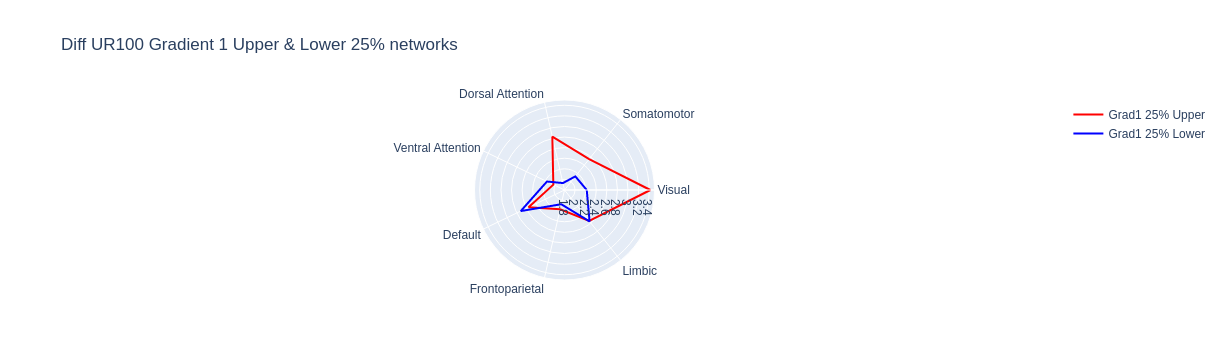

In [93]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=grad1_25_network_df['Grad1 25% Upper'].values.tolist() + grad1_25_network_df['Grad1 25% Upper'].values.tolist()[:1], theta=grad1_25_network_df['networks'].tolist() + grad1_25_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'red', name='Grad1 25% Upper'))
fig.add_trace(go.Scatterpolar(r=grad1_25_network_df['Grad1 25% Lower'].values.tolist() + grad1_25_network_df['Grad1 25% Lower'].values.tolist()[:1], theta=grad1_25_network_df['networks'].tolist() + grad1_25_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'blue', name='Grad1 25% Lower'))

fig.update_layout(polar=dict(radialaxis=dict(visible=True, range=[1.8, 3.5])),title = 'Diff UR100 Gradient 1 Upper & Lower 25% networks', showlegend=True)

fig.show()
fig.write_image(fig_path+'Diff_UR100_Gradient1_Upper&Lower_25%_networks.png')

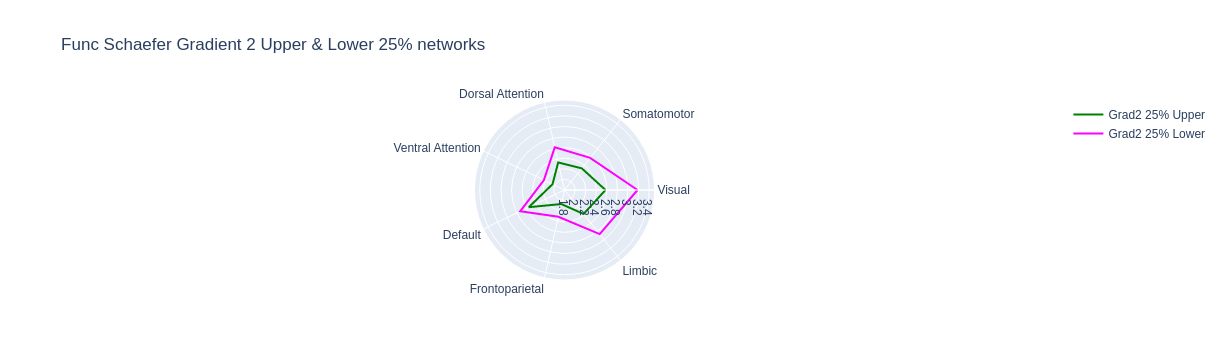

In [94]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=grad2_25_network_df['Grad2 25% Upper'].values.tolist() + grad2_25_network_df['Grad2 25% Upper'].values.tolist()[:1], theta=grad2_25_network_df['networks'].tolist() + grad2_25_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'green', name='Grad2 25% Upper'))
fig.add_trace(go.Scatterpolar(r=grad2_25_network_df['Grad2 25% Lower'].values.tolist() + grad2_25_network_df['Grad2 25% Lower'].values.tolist()[:1], theta=grad2_25_network_df['networks'].tolist() + grad2_25_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'fuchsia', name='Grad2 25% Lower'))

fig.update_layout(polar=dict(radialaxis=dict(visible=True, range=[1.8, 3.5])),title = 'Func Schaefer Gradient 2 Upper & Lower 25% networks', showlegend=True)

fig.show()
fig.write_image(fig_path+'Func_Schaefer_Gradient2_Upper&Lower_25%_networks.png')

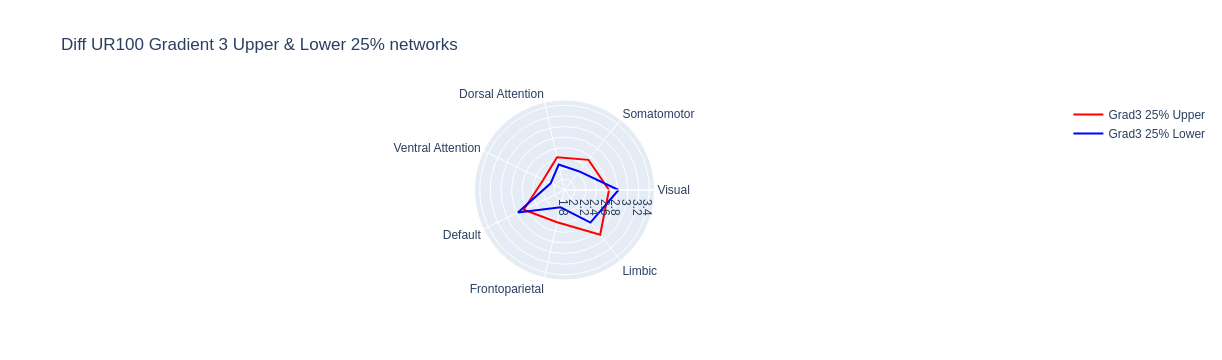

In [95]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=grad3_25_network_df['Grad3 25% Upper'].values.tolist() + grad3_25_network_df['Grad3 25% Upper'].values.tolist()[:1], theta=grad3_25_network_df['networks'].tolist() + grad3_25_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'red', name='Grad3 25% Upper'))
fig.add_trace(go.Scatterpolar(r=grad3_25_network_df['Grad3 25% Lower'].values.tolist() + grad3_25_network_df['Grad3 25% Lower'].values.tolist()[:1], theta=grad3_25_network_df['networks'].tolist() + grad3_25_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'blue', name='Grad3 25% Lower'))

fig.update_layout(polar=dict(radialaxis=dict(visible=True, range=[1.8, 3.5])),title = 'Diff UR100 Gradient 3 Upper & Lower 25% networks', showlegend=True)

fig.show()
fig.write_image(fig_path+'Diff_UR100_Gradient3_Upper&Lower_25%_networks.png')

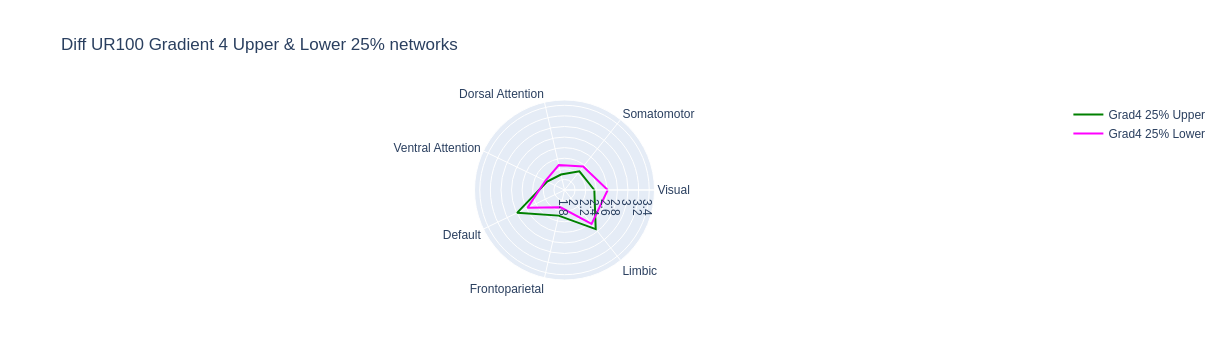

In [123]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=grad4_25_network_df['Grad4 25% Upper'].values.tolist() + grad4_25_network_df['Grad4 25% Upper'].values.tolist()[:1], theta=grad4_25_network_df['networks'].tolist() + grad4_25_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'green', name='Grad4 25% Upper'))
fig.add_trace(go.Scatterpolar(r=grad4_25_network_df['Grad4 25% Lower'].values.tolist() + grad4_25_network_df['Grad4 25% Lower'].values.tolist()[:1], theta=grad4_25_network_df['networks'].tolist() + grad4_25_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'fuchsia', name='Grad4 25% Lower'))

fig.update_layout(polar=dict(radialaxis=dict(visible=True, range=[1.8, 3.5])),title = 'Diff UR100 Gradient 4 Upper & Lower 25% networks', showlegend=True)

fig.show()
fig.write_image(fig_path+'Diff_UR100_Gradient4_Upper&Lower_25%_networks.png')

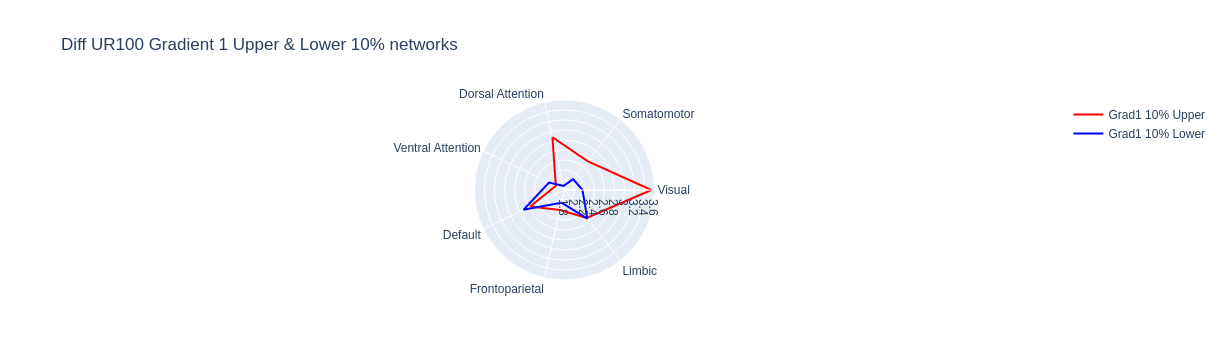

In [97]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=grad1_10_network_df['Grad1 10% Upper'].values.tolist() + grad1_10_network_df['Grad1 10% Upper'].values.tolist()[:1], theta=grad1_10_network_df['networks'].tolist() + grad1_10_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'red', name='Grad1 10% Upper'))
fig.add_trace(go.Scatterpolar(r=grad1_10_network_df['Grad1 10% Lower'].values.tolist() + grad1_10_network_df['Grad1 10% Lower'].values.tolist()[:1], theta=grad1_10_network_df['networks'].tolist() + grad1_10_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'blue', name='Grad1 10% Lower'))

fig.update_layout(polar=dict(radialaxis=dict(visible=True, range=[1.8, 3.6])),title = 'Diff UR100 Gradient 1 Upper & Lower 10% networks', showlegend=True)

fig.show()
fig.write_image(fig_path+'Diff_UR100_Gradient1_Upper&Lower_10%_networks.png')

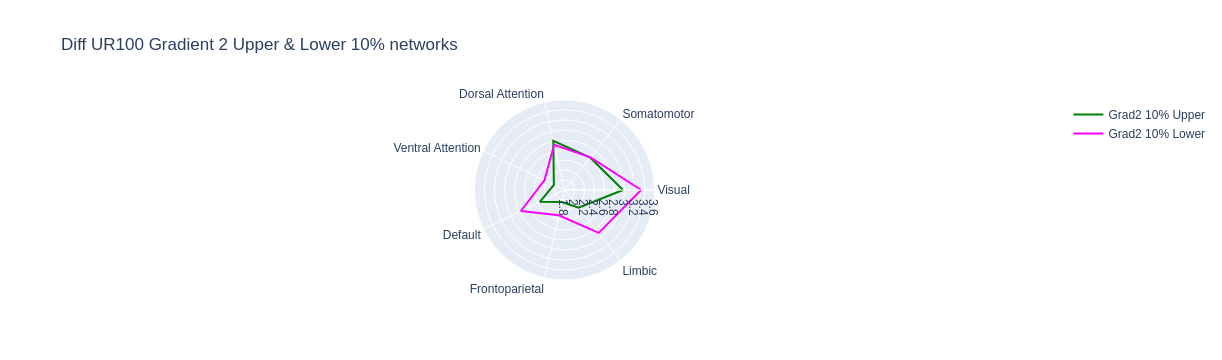

In [124]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=grad2_10_network_df['Grad2 10% Upper'].values.tolist() + grad2_10_network_df['Grad2 10% Upper'].values.tolist()[:1], theta=grad2_10_network_df['networks'].tolist() + grad2_10_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'green', name='Grad2 10% Upper'))
fig.add_trace(go.Scatterpolar(r=grad2_10_network_df['Grad2 10% Lower'].values.tolist() + grad2_10_network_df['Grad2 10% Lower'].values.tolist()[:1], theta=grad2_10_network_df['networks'].tolist() + grad2_10_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'fuchsia', name='Grad2 10% Lower'))

fig.update_layout(polar=dict(radialaxis=dict(visible=True, range=[1.8, 3.6])),title = 'Diff UR100 Gradient 2 Upper & Lower 10% networks', showlegend=True)

fig.show()
fig.write_image(fig_path+'Diff_UR100_Gradient2_Upper&Lower_10%_networks.png')

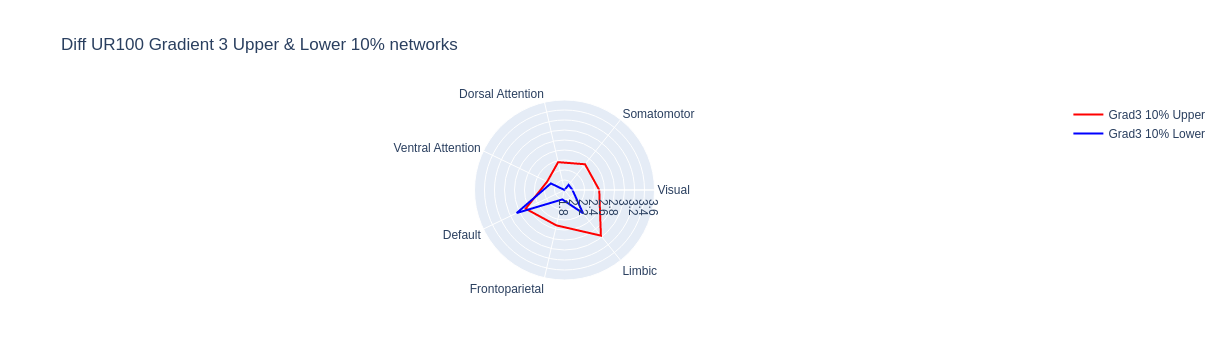

In [99]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=grad3_10_network_df['Grad3 10% Upper'].values.tolist() + grad3_10_network_df['Grad3 10% Upper'].values.tolist()[:1], theta=grad3_10_network_df['networks'].tolist() + grad3_10_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'red', name='Grad3 10% Upper'))
fig.add_trace(go.Scatterpolar(r=grad3_10_network_df['Grad3 10% Lower'].values.tolist() + grad3_10_network_df['Grad3 10% Lower'].values.tolist()[:1], theta=grad3_10_network_df['networks'].tolist() + grad3_10_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'blue', name='Grad3 10% Lower'))

fig.update_layout(polar=dict(radialaxis=dict(visible=True, range=[1.8, 3.6])),title = 'Diff UR100 Gradient 3 Upper & Lower 10% networks', showlegend=True)

fig.show()
fig.write_image(fig_path+'Diff_UR100_Gradient3_Upper&Lower_10%_networks.png')

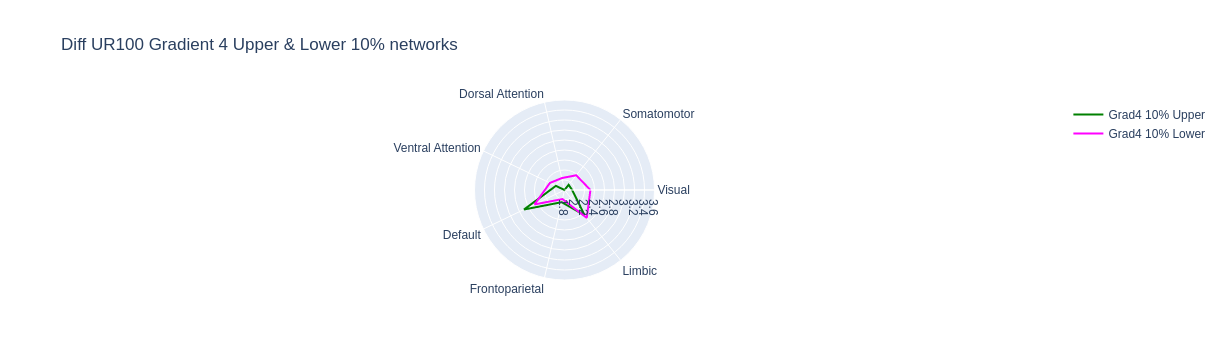

In [125]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=grad4_10_network_df['Grad4 10% Upper'].values.tolist() + grad4_10_network_df['Grad4 10% Upper'].values.tolist()[:1], theta=grad4_10_network_df['networks'].tolist() + grad4_10_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'green', name='Grad4 10% Upper'))
fig.add_trace(go.Scatterpolar(r=grad4_10_network_df['Grad4 10% Lower'].values.tolist() + grad4_10_network_df['Grad4 10% Lower'].values.tolist()[:1], theta=grad4_10_network_df['networks'].tolist() + grad4_10_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'fuchsia', name='Grad4 10% Lower'))

fig.update_layout(polar=dict(radialaxis=dict(visible=True, range=[1.8, 3.6])),title = 'Diff UR100 Gradient 4 Upper & Lower 10% networks', showlegend=True)

fig.show()
fig.write_image(fig_path+'Diff_UR100_Gradient4_Upper&Lower_10%_networks.png')

### Upper and Lower gradient cortical projection

In [101]:
# Upper
grad1_25upperFCavg = np.nanmean(grad1_25upperFC,axis=0).reshape([360,1])
grad1_10upperFCavg = np.nanmean(grad1_10upperFC,axis=0).reshape([360,1])
grad2_25upperFCavg = np.nanmean(grad2_25upperFC,axis=0).reshape([360,1])
grad2_10upperFCavg = np.nanmean(grad2_10upperFC,axis=0).reshape([360,1])

In [102]:
grad3_25upperFCavg = np.nanmean(grad3_25upperFC,axis=0).reshape([360,1])
grad3_10upperFCavg = np.nanmean(grad3_10upperFC,axis=0).reshape([360,1])
grad4_25upperFCavg = np.nanmean(grad4_25upperFC,axis=0).reshape([360,1])
grad4_10upperFCavg = np.nanmean(grad4_10upperFC,axis=0).reshape([360,1])

In [103]:
# Lower
grad1_25lowerFCavg = np.nanmean(grad1_25lowerFC,axis=0).reshape([360,1])
grad1_10lowerFCavg = np.nanmean(grad1_10lowerFC,axis=0).reshape([360,1])
grad2_25lowerFCavg = np.nanmean(grad2_25lowerFC,axis=0).reshape([360,1])
grad2_10lowerFCavg = np.nanmean(grad2_10lowerFC,axis=0).reshape([360,1])

In [104]:
grad3_25lowerFCavg = np.nanmean(grad3_25lowerFC,axis=0).reshape([360,1])
grad3_10lowerFCavg = np.nanmean(grad3_10lowerFC,axis=0).reshape([360,1])
grad4_25lowerFCavg = np.nanmean(grad4_25lowerFC,axis=0).reshape([360,1])
grad4_10lowerFCavg = np.nanmean(grad4_10lowerFC,axis=0).reshape([360,1])

In [105]:
# setting up for cortical projection using brainspace
surf_lh, surf_rh = load_fsa5()

surf_labels_lh = nib.freesurfer.read_annot(data_path + 'lh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh = nib.freesurfer.read_annot(data_path + 'rh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh[surf_labels_rh != 0] += 180  # different labels for lh and rh
surf_labels = np.concatenate([surf_labels_lh, surf_labels_rh])

mask = surf_labels != 0  # discard medial wall

In [106]:
# Upper
G1upper25cortex = map_to_labels(grad1_25upperFCavg.reshape([360]),surf_labels, mask=mask, fill=np.nan)
G1upper10cortex = map_to_labels(grad1_10upperFCavg.reshape([360]),surf_labels, mask=mask, fill=np.nan)
G2upper25cortex = map_to_labels(grad2_25upperFCavg.reshape([360]),surf_labels, mask=mask, fill=np.nan)
G2upper10cortex = map_to_labels(grad2_10upperFCavg.reshape([360]),surf_labels, mask=mask, fill=np.nan)

In [107]:
G3upper25cortex = map_to_labels(grad3_25upperFCavg.reshape([360]),surf_labels, mask=mask, fill=np.nan)
G3upper10cortex = map_to_labels(grad3_10upperFCavg.reshape([360]),surf_labels, mask=mask, fill=np.nan)
G4upper25cortex = map_to_labels(grad4_25upperFCavg.reshape([360]),surf_labels, mask=mask, fill=np.nan)
G4upper10cortex = map_to_labels(grad4_10upperFCavg.reshape([360]),surf_labels, mask=mask, fill=np.nan)

In [108]:
# Lower
G1lower25cortex = map_to_labels(grad1_25lowerFCavg.reshape([360]),surf_labels, mask=mask, fill=np.nan)
G1lower10cortex = map_to_labels(grad1_10lowerFCavg.reshape([360]),surf_labels, mask=mask, fill=np.nan)
G2lower25cortex = map_to_labels(grad2_25lowerFCavg.reshape([360]),surf_labels, mask=mask, fill=np.nan)
G2lower10cortex = map_to_labels(grad2_10lowerFCavg.reshape([360]),surf_labels, mask=mask, fill=np.nan)

In [109]:
G3lower25cortex = map_to_labels(grad3_25lowerFCavg.reshape([360]),surf_labels, mask=mask, fill=np.nan)
G3lower10cortex = map_to_labels(grad3_10lowerFCavg.reshape([360]),surf_labels, mask=mask, fill=np.nan)
G4lower25cortex = map_to_labels(grad4_25lowerFCavg.reshape([360]),surf_labels, mask=mask, fill=np.nan)
G4lower10cortex = map_to_labels(grad4_10lowerFCavg.reshape([360]),surf_labels, mask=mask, fill=np.nan)

In [110]:
# Plot on the surface and save the fig.
plot_hemispheres(surf_lh, surf_rh, array_name=[G1upper25cortex], label_text=['Grad1 upper 25%'],
    size=(800, 200),  cmap=['Reds'], color_bar=True, embed_nb=True, screenshot=True, filename=fig_path+'Diff_UR100_Grad1_Upper25%_cortex.png')

'/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/HumanBF-Parcellation/results/figures/Diff_UR100/Diff_UR100_Grad1_Upper25%_cortex.png'

In [111]:
# Plot on the surface and save the fig.
plot_hemispheres(surf_lh, surf_rh, array_name=[G1upper10cortex], label_text=['Grad1 upper 10%'],
    size=(800, 200),  cmap=['Reds'], color_bar=True, embed_nb=True, screenshot=True, filename=fig_path+'Diff_UR100_Grad1_Upper10%_cortex.png')

'/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/HumanBF-Parcellation/results/figures/Diff_UR100/Diff_UR100_Grad1_Upper10%_cortex.png'

In [112]:
plot_hemispheres(surf_lh, surf_rh, array_name=[G1lower25cortex], label_text=['Grad1 lower 25%'],
    size=(800, 200),  cmap=['Blues'], color_bar=True, embed_nb=True, screenshot=True, filename=fig_path+'Diff_UR100_Grad1_Lower25%_cortex.png')

'/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/HumanBF-Parcellation/results/figures/Diff_UR100/Diff_UR100_Grad1_Lower25%_cortex.png'

In [113]:
plot_hemispheres(surf_lh, surf_rh, array_name=[G1lower10cortex], label_text=['Grad1 lower 10%'],
    size=(800, 200),  cmap=['Blues'], color_bar=True, embed_nb=True, screenshot=True, filename=fig_path+'Diff_UR100_Grad1_Lower10%_cortex.png')

'/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/HumanBF-Parcellation/results/figures/Diff_UR100/Diff_UR100_Grad1_Lower10%_cortex.png'

In [114]:
plot_hemispheres(surf_lh, surf_rh, array_name=[G2upper25cortex], label_text=['Grad2 upper 25%'],
    size=(800, 200),  cmap=['Greens'], color_bar=True, embed_nb=True, screenshot=True, filename=fig_path+'Diff_UR100_Grad2_Upper25%_cortex.png')

'/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/HumanBF-Parcellation/results/figures/Diff_UR100/Diff_UR100_Grad2_Upper25%_cortex.png'

In [115]:
plot_hemispheres(surf_lh, surf_rh, array_name=[G2upper10cortex], label_text=['Grad2 upper 10%'],
    size=(800, 200),  cmap=['Greens'], color_bar=True, embed_nb=True, screenshot=True, filename=fig_path+'Diff_UR100_Grad2_Upper10%_cortex.png')

'/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/HumanBF-Parcellation/results/figures/Diff_UR100/Diff_UR100_Grad2_Upper10%_cortex.png'

In [116]:
plot_hemispheres(surf_lh, surf_rh, array_name=[G2lower25cortex], label_text=['Grad2 lower 25%'],
    size=(800, 200),  cmap=['RdPu'], color_bar=True, embed_nb=True, screenshot=True, filename=fig_path+'Diff_UR100_Grad2_Lower25%_cortex.png')

'/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/HumanBF-Parcellation/results/figures/Diff_UR100/Diff_UR100_Grad2_Lower25%_cortex.png'

In [117]:
plot_hemispheres(surf_lh, surf_rh, array_name=[G2lower10cortex], label_text=['Grad2 lower 10%'],
    size=(800, 200),  cmap=['RdPu'], color_bar=True, embed_nb=True, screenshot=True, filename=fig_path+'Diff_UR100_Grad2_Lower10%_cortex.png')

'/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/HumanBF-Parcellation/results/figures/Diff_UR100/Diff_UR100_Grad2_Lower10%_cortex.png'

In [118]:
# Save the cortical projection as gii files
# Upper 25%
G_cortex = [G1upper25cortex, G2upper25cortex, G3upper25cortex, G4upper25cortex]

for g in range(0, len(G_cortex)):
    gii_L = nib.gifti.GiftiImage()
    gii_L.add_gifti_data_array(
        nib.gifti.GiftiDataArray(G_cortex[g][:10242].astype(np.float32))) # For left hemisphere
    nib.save(gii_L, results_path+'Diff_UR100_Gradient-'+str(g+1)+'_Upper25%_L_fsa-10k.gii')

for g in range(0, len(G_cortex)):
    gii_R = nib.gifti.GiftiImage()
    gii_R.add_gifti_data_array(
        nib.gifti.GiftiDataArray(G_cortex[g][10242:].astype(np.float32))) # right hemisphere is [32492:]
    nib.save(gii_R, results_path+'Diff_UR100_Gradient-'+str(g+1)+'_Upper25%_R_fsa-10k.gii')

In [119]:
# Lower 25%
G_cortex = [G1lower25cortex, G2lower25cortex, G3lower25cortex, G4lower25cortex]

for g in range(0, len(G_cortex)):
    gii_L = nib.gifti.GiftiImage()
    gii_L.add_gifti_data_array(
        nib.gifti.GiftiDataArray(G_cortex[g][:10242].astype(np.float32))) # For left hemisphere
    nib.save(gii_L, results_path+'Diff_UR100_Gradient-'+str(g+1)+'_Lower25%_L_fsa-10k.gii')

for g in range(0, len(G_cortex)):
    gii_R = nib.gifti.GiftiImage()
    gii_R.add_gifti_data_array(
        nib.gifti.GiftiDataArray(G_cortex[g][10242:].astype(np.float32))) # right hemisphere is [32492:]
    nib.save(gii_R, results_path+'Diff_UR100_Gradient-'+str(g+1)+'_Lower25%_R_fsa-10k.gii')

In [120]:
# Upper 10%
G_cortex = [G1upper10cortex, G2upper10cortex, G3upper10cortex, G4upper10cortex]

for g in range(0, len(G_cortex)):
    gii_L = nib.gifti.GiftiImage()
    gii_L.add_gifti_data_array(
        nib.gifti.GiftiDataArray(G_cortex[g][:10242].astype(np.float32))) # For left hemisphere
    nib.save(gii_L, results_path+'Diff_UR100_Gradient-'+str(g+1)+'_Upper10%_L_fsa-10k.gii')

for g in range(0, len(G_cortex)):
    gii_R = nib.gifti.GiftiImage()
    gii_R.add_gifti_data_array(
        nib.gifti.GiftiDataArray(G_cortex[g][10242:].astype(np.float32))) # right hemisphere is [32492:]
    nib.save(gii_R, results_path+'Diff_UR100_Gradient-'+str(g+1)+'_Upper10%_R_fsa-10k.gii')

In [121]:
# Lower 10%
G_cortex = [G1lower10cortex, G2lower10cortex, G3lower10cortex, G4lower10cortex]

for g in range(0, len(G_cortex)):
    gii_L = nib.gifti.GiftiImage()
    gii_L.add_gifti_data_array(
        nib.gifti.GiftiDataArray(G_cortex[g][:10242].astype(np.float32))) # For left hemisphere
    nib.save(gii_L, results_path+'Diff_UR100_Gradient-'+str(g+1)+'_Lower10%_L_fsa-10k.gii')

for g in range(0, len(G_cortex)):
    gii_R = nib.gifti.GiftiImage()
    gii_R.add_gifti_data_array(
        nib.gifti.GiftiDataArray(G_cortex[g][10242:].astype(np.float32))) # right hemisphere is [32492:]
    nib.save(gii_R, results_path+'Diff_UR100_Gradient-'+str(g+1)+'_Lower10%_R_fsa-10k.gii')

### Visualize Upper and Lower gradient cortical projection

/home/ROBARTS/schakraborty/venv/lib/python3.9/site-packages/brainspace/plotting/base.py:287: UserWarning:

Interactive mode requires 'panel'. Setting 'interactive=False'



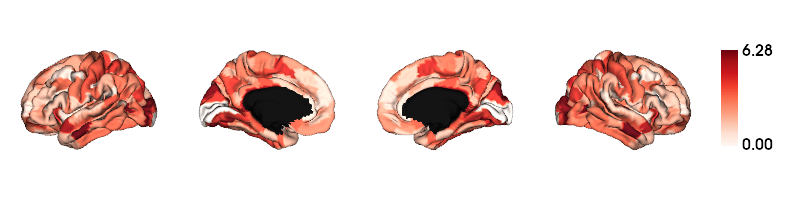

In [122]:
grad_L = images.load_gifti(results_path+'Diff_UR100_Gradient-1_Upper25%_L_fsa-10k.gii')
grad_R = images.load_gifti(results_path+'Diff_UR100_Gradient-1_Upper25%_R_fsa-10k.gii')
grad_L_data = grad_L.agg_data()
grad_R_data = grad_R.agg_data()
grad_data = np.concatenate((grad_L_data, grad_R_data))

surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[grad_data], size=(800, 200), cmap=['Reds'], color_bar=True, embed_nb=True)